# Regularized Saturated Models for Classification Tasks with Categorical Variables

Contingency tables are great for probablilty mass estimation, but can also be used for classification and regression tasks. 


Assume we have $M$ independent variables, for which we will use $i$, $j$, $k$ to denote an index. We also have one dependent variable, the values of which is are indexed using $v$. Then the classification problem can be written as :

$$ p(y_v | x_{ij\ldots k}) = \frac{p_{vij\ldots k}}{p_{+ij\ldots k}} $$

Here the symbol $+$ implies taking a sum, like in this example:

$$ p_{i+} = \sum_k{p_{ik}} $$

So if we have the probability mass problem solved it is trivial to solve the classification problem as well. 

To estimate $p_{vij\ldots k}$, we take the counts of the training data $m_{vij\ldots k}$ and use a Multinomial model with the following log-likelihood:

$$ L = \sum_{vij\ldots k}{m_{vij\ldots k}log p_{vij\ldots k}}$$




## Naive Bayes prior

The likelihood function above is the same as for the probability mass estimate, but the prior is slightly different. Here our prior assumptions are that the data can be classified using Naive Bayes algorithm and a weaker assumption that all the variables are independent (we need that weaker assumption to make sure none of the probabilities $p_{vij\ldots k}$ are zero.

The Naive Bayes assumption can be expressed like this:

$$ p_{vij\ldots k} = p(y, x_1\ldots x_M) = p(y) \prod_{m=1}^M{p(x_m|y)} = \big[p(y)\big]^{1-M} \prod_{m=1}^M{p(x_m,y)} $$

Here $p(x_m|y)$ is derived by summing along all indexes except y and m

## Independence prior

Independence prior is also very simple:

$$ p_{vij\ldots k} = p(y) \prod_{m=1}^M{p(x_m)}$$


## Posterior distribution

Here we will bring together likelihood and both prior distributions.

Let:

$$ R_{vij\ldots k} = \lambda_1\big(\big[p(y)\big]^{1-M} \prod_{m=1}^M{p(x_m,y)}\big) + \lambda_2 \big( p(y) \prod_{m=1}^M{p(x_m)}\big), $$

where $\lambda_1$ and $\lambda_2$ are hyperparameters.

Then the log of the posterior distribution is:

$$ \mathcal{P} = \sum_{vij\ldots k}({m_{vij\ldots k} + R_{vij\ldots k})log p_{vij\ldots k}} - \sum_{ij}{log \Gamma(R_{vij\ldots k})}$$






## Mercedes-Benz data

In [57]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder,KBinsDiscretizer
import functools

In [9]:
all_data = pd.read_csv('data/train.csv.zip')
kaggle_test_data = pd.read_csv('data/test.csv.zip')
combined = pd.concat([all_data, kaggle_test_data], axis=0, sort=False)
cat_column_names = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
label_encoders = {col: LabelEncoder().fit(combined[col]) for col in cat_column_names}

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:

    # Removing duplicate or constant columns
    # as per https://www.kaggle.com/yohanb/categorical-features-encoding-xgb-0-554
    columns_to_remove = ['X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347',
                     'X382', 'X232', 'X279', 'X35', 'X37', 'X39', 'X302', 'X113', 'X134', 'X147', 'X222',
                     'X102', 'X214', 'X239', 'X76', 'X324', 'X248', 'X253', 'X385', 'X172', 'X216', 'X213',
                     'X84', 'X244', 'X122', 'X243', 'X320', 'X245', 'X94', 'X242', 'X199', 'X119', 'X227',
                     'X146', 'X226', 'X326', 'X360', 'X262', 'X266', 'X247', 'X254', 'X364', 'X365', 'X296', 'X299',
                     'X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
    data1 = df.drop(columns=columns_to_remove)
    for col, encoder in label_encoders.items():
        data1[col] = encoder.transform(data1[col])
        
    return data1

train_data = preprocess_data(all_data)
kaggle_data = preprocess_data(kaggle_test_data)



## Discretizing the target variable

In this task the target variable y is actually continuous. Here  is the histogram of this variable:

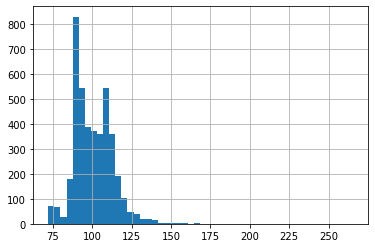

In [15]:
train_data.iloc[:,1].hist(bins=50);

This is a multimodal distribution with a certain degree of smoothness. To change it to a continuous variable we can discretize it.

In [22]:
# This really should be done on the training set.
# We will do that once we make sure the model is working
discretizer = KBinsDiscretizer(n_bins=50, encode='ordinal', )
discretized_y = discretizer.fit_transform(train_data.y.values.reshape(-1, 1))

In [37]:
# This function does inverse transform, given an array of probabilities
def inverse_discretizer(discretizer, probabilities):
    assert discretizer.n_bins_ == probabilities.shape[-1]
    all_options = np.arange(discretizer.n_bins_).reshape(-1,1)
    all_options_transformed = discretizer.inverse_transform(all_options)
    expected_y = probabilities @ all_options_transformed
    return expected_y

In [44]:
def test_inverse_discretizer():
    discretizer = KBinsDiscretizer(n_bins=50, encode='ordinal', )
    discretized_y = discretizer.fit_transform(train_data.y.values.reshape(-1, 1))
    probabilities = np.zeros([5, 50])
    probabilities[:,-1] = 1
    print(inverse_discretizer(discretizer, probabilities))

In [45]:
test_inverse_discretizer()

[[197.3096]
 [197.3096]
 [197.3096]
 [197.3096]
 [197.3096]]


## Training the deep learning model

First we need to figure out the shape of the parameter array

In [50]:
# Find the shape of the parameter array
def get_parameter_shape(input_array):
    return tuple(np.max(input_array, axis=0).astype(int))

In [56]:
test_shape = get_parameter_shape(train_data.iloc[:,2:])
len(test_shape)

319

In [9]:
def train_model(data, lambda_1, lambda_2, epochs, verbose=False):
    """
    data: assuming the first column is discretized y!
    """
    shape = get_parameter_shape(data)
    data = data.astype(int)
      
    c_init = tf.zeros_initializer()
    c = tf.Variable(initial_value=c_init(shape=shape, dtype="float32"), trainable=True)
    
    def _get_probabilities():
        c_flattened = tf.reshape(c, (1,-1))
        p = tf.reshape(tf.nn.softmax(c_flattened), shape)
        log_p = tf.reshape(tf.nn.log_softmax(c_flattened), shape)
        return p, log_p
    
    def compute_loss():
        epsilon = 1E-10
        p, log_p = _get_probabilities()
        
        #Marginal probabilities
        all_dimensions = list(range(len(shape)))
        p1 = [tf.reduce_sum(p, all_dimensions-[i], keepdims=True) for i in all_dimensions]
        if verbose:
            print('p1[5].shape', p1[5].shape)
        marginal_p = functools.reduce(tf.multiply, p1)
        
        #Probabilities of naive-bayes
        x_dimensions = list(range(1,len(shape)))
        p2 = [tf.reduce_sum(p, x_dimensions-[i], keepdims=True) for i in x_dimensions]
        if verbose:
            print('p2[5].shape', p2[5].shape)
        naive_bayes = functools.reduce(tf.multiply, p2)
        naive_bayes = p1[0] ** (-len(x_dimensions)) * naive_bayes
        
        //what's next?
        
        
        
        
        
        
        loss_array = - (data + regularization * p12) * log_p + \
            tf.math.lgamma(regularization * p12 + epsilon)
        return tf.reduce_mean(loss_array, axis=None)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=3.0)
    for i in range(epochs):
        optimizer.minimize(compute_loss, var_list=[c])
        if (i % 20 == 0) and verbose:
            print(compute_loss().numpy())
    
    
    return _get_probabilities()[0].numpy()

Here's the quick rundown of the code:
1. The probabilities $p_{ij}$ take the values between 0 and 1 and should all add up to 1. For this reason I used a common trick and use `softmax` function that takes a variable $c$ and produces $p$ that satisfies these constraints. Correspondingly, the model learns the values of $c$.
1. TensorFlow also provides function `log_softmax` that helps avoid the case of extreme large values returned by `softmax`
1. The code is using TensorFlow 2.x. So instead of using `Session.run()` we just call a function (in our case `_get_probabilities()`). Honestly, I don't miss TensorFlow 1.x
1. To compute $p_{i+} p_{+j}$ we use matrix multiplication. It is the fastest way.
1. Function `lgamma()` is used instead of computing Gamma function first then taking a log
1. Gamma function of zero is not defined. This makes the cost function unstable. To deal with that we add a small positive value `epsilon` to the argument, which takes care of the issue.
1. We have a custom training loop and using Adam optimizer. 
1. The function returns an Numpy array of probabilities.

Let's train the model for several values of the regularization parameter $\lambda$:


In [25]:
result = run_experiment(salary_experience_array, 0, 200, False)
metric(salary_experience_array, result * np.sum(salary_experience_array))

{'Dependence': 0.41516, 'Fit to data': 0.0}

In [28]:
probabilities = to_data_frame(result)
probabilities* np.sum(salary_experience_array)

,0-2,3-5,6-8,9-11,12-14,15-17,18-23,24-29,30+
950-1350,7.00018e+00,9.99985e-01,0.99999,4.35136e-10,4.35136e-10,4.35136e-10,4.35136e-10,1.99981e+00,4.35136e-10
1351-1750,9.99979e+00,5.99975e+00,5.00068,3.00008e+00,4.35136e-10,9.99985e-01,9.99985e-01,9.99985e-01,4.35136e-10
1751-2150,1.19995e+01,1.39998e+01,7.00018,9.99985e-01,3.99997e+00,1.99981e+00,1.99981e+00,9.99985e-01,1.99981e+00
2151-2550,4.35136e-10,9.99985e-01,8.00024,3.00008e+00,3.00008e+00,3.00008e+00,5.00068e+00,4.35136e-10,3.99997e+00
2551-2950,4.35136e-10,4.35136e-10,3.00008,1.99981e+00,4.35136e-10,5.99975e+00,5.00068e+00,1.99981e+00,7.00018e+00
2951-3750,9.99985e-01,4.35136e-10,0.99999,4.35136e-10,9.99985e-01,9.99985e-01,5.99975e+00,4.35136e-10,1.99981e+00


As we see, the predicted counts match the training data very closely. Let's see what the predictions would be for high value of regularization

In [31]:
result = run_experiment(salary_experience_array, 500, 100, False)
metric(salary_experience_array, result * np.sum(salary_experience_array))

{'Dependence': 0.01823, 'Fit to data': 41.26035}

In [32]:
probabilities = to_data_frame(result)
probabilities* np.sum(salary_experience_array)

,0-2,3-5,6-8,9-11,12-14,15-17,18-23,24-29,30+
950-1350,3.38174,1.60395,1.87039,0.68084,0.68074,0.93380,1.20386,1.02942,1.03341
1351-1750,6.01283,4.24254,4.69361,2.21369,1.36878,2.31144,2.69139,1.40190,2.14210
1751-2150,8.47464,7.62323,7.02657,2.62612,3.14746,3.58306,4.34500,2.05495,3.76672
2151-2550,3.69015,3.08018,5.13886,2.19541,2.05561,2.68246,3.58932,1.13517,2.97027
2551-2950,3.39100,2.54829,3.81662,1.89522,1.24359,3.16261,3.39575,1.54948,3.48342
2951-3750,2.20832,1.55586,2.11060,0.78373,0.94152,1.36490,2.67640,0.61857,1.57253


We see that the dependence is much lower, and the predictions is much more smooth, meaning that there are no zeros or exreme values. However the model does not fit very well to the data. How to find optimal regularization parameter $\lambda$? We will use cross-validation, a common method in machine learning.

## Cross-validation
Our plan is to generate five folds of data and run the train the model for different values of the regularization hyperparameter. For every split we train the model on the training data and test it on the test data. As a metric here we use cross-entropy loss (the first component returning by the `result_metric` function). We use grid search in logarithmic scale.

In [12]:
def sample_single(data, test_fraction):
    """Create train and test set"""
    test = np.zeros(shape=data.shape)
    for i in range(test.shape[0]):
        for j in range(test.shape[1]):
            test[i,j] = np.sum(np.random.choice([0,1], size=data[i,j], p=[1-test_fraction, test_fraction]))
    return data - test, test

In [13]:
#Generating 5 folds
np.random.seed(2128506)
splits = [sample_single(salary_experience_array, 0.2) for _ in range(5)]

In [14]:
def run_cv(data, regularization, epochs, verbose=False):
    cs_sum = 0
    for train, test in splits:
        result = run_experiment(train, regularization, epochs, verbose)
        result_metric = metric(test, result * np.sum(test))
        cs_sum += result_metric['Fit to data']
    return cs_sum / len(data)
    

In [15]:
cv_results = {regularization: run_cv(salary_experience_array, regularization, 300) 
              for regularization in [0,2,4,8,16,64,128, 256]}

In [16]:
cv_results

{0: -277.8866566666667,
 2: -314.990695,
 4: -316.59107166666666,
 8: -318.0676583333333,
 16: -319.3135016666667,
 64: -320.434535,
 128: -320.05407833333334,
 256: -319.23017}

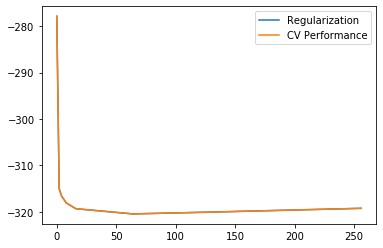

In [17]:
results_df = pd.DataFrame(cv_results, index=['Regularization', "CV Performance"])
results_df.T.plot();

Based on the cross-validation results the best performance of the model happens when $\lambda = 64$. We can also see that the model performance changes little after $\lambda = 4$. Perhaps it makes sense to average several models of comparable performance. Let's see the results generated by the best model:

In [33]:
result = run_experiment(salary_experience_array, 64, 500, False)
metric(salary_experience_array, result * np.sum(salary_experience_array))

{'Dependence': 0.1763, 'Fit to data': 12.90124}

In [34]:
probabilities = to_data_frame(result)
probabilities* np.sum(salary_experience_array)

,0-2,3-5,6-8,9-11,12-14,15-17,18-23,24-29,30+
950-1350,5.68973,1.30630,1.50247,0.35553,0.32165,0.43054,0.53850,2.22560,0.44372
1351-1750,7.71055,5.01276,4.78635,2.98537,0.58018,1.51411,1.66769,1.36694,0.81316
1751-2150,9.47247,10.56914,6.71977,1.73339,3.90291,2.61106,2.83336,1.61330,2.59546
2151-2550,1.34993,1.69919,6.76907,2.93928,2.88506,2.93574,4.30820,0.53217,3.55131
2551-2950,1.20816,0.93791,3.19687,2.07677,0.51816,4.92782,4.20533,2.07660,5.44199
2951-3750,1.50375,0.62231,1.57091,0.39049,1.24524,1.29622,5.13467,0.32709,2.04776


We see a good balance between prediction smoothness and how well it fit the training data.

## Conclusion
Here we considered a fully Bayesian approach for contingency table smoothing. This approach is different from pseudo-Bayes approach [2,3], where the prior distribution is defined using the data. We can take advantage of compute power that was not available in the 1970s, and use the true Bayesian approach to get more consistent results. It is certainly possible to use the same method for a higher number of dimensions as most real world data are. In this article I used a two dimensional contingency table solely because it is much easier to visualize than multidimensional tables.

## References

[1] Alan Agresti, Categorical data analysis, Whiley, 1990

[2] Yvonne Bishop et al., Discrete Multivariate Analysis, MIT, 1975

[3] Stephen E. Fienberg and Paul W. Holland, Simultaneous Estimation of Multinomial
Cell Probabilities, Journal of the American Statistical Association 68(343):683-691, 1973